## Agrupación de IPs por sus palabras clave

Paso 1: Cargar el dataset

In [1]:
import pandas as pd

df = pd.read_csv("Keywords/author_keyword_matrix.csv", index_col=0)

# Mostrar resumen
print("✅ Dataset generado con forma:", df.shape)
print("🔢 Palabras clave totales:", len(df.columns))
print("👥 Autores con keywords:", len(df))

✅ Dataset generado con forma: (29, 3329)
🔢 Palabras clave totales: 3329
👥 Autores con keywords: 29


Paso 2: Preprocesamiento (normalización y reducción PCA)

In [2]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

X = df.values
X_normalized = Normalizer().fit_transform(X)

Paso 3: Clustering con HDBSCAN

In [3]:
# === Configuraciones de preprocesamiento y clustering ===
pca_dims = [2, 5, 10, 20]
eps_values = [0.3, 0.5, 0.7, 0.9, 1.2]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluar KMeans para k entre 2 y 15
results = []

for n_dim in pca_dims:
    X_reduced = PCA(n_components=n_dim).fit_transform(X_normalized)

    for eps in eps_values:
        try:
            model = DBSCAN(eps=eps, min_samples=2)
            labels = model.fit_predict(X_reduced)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette = silhouette_score(X_reduced, labels)
                ch_score = calinski_harabasz_score(X_reduced, labels)
                db_score = davies_bouldin_score(X_reduced, labels)
            else:
                silhouette = ch_score = db_score = np.nan

            results.append({
                "PCA_dims": n_dim,
                "eps": eps,
                "Clusters": n_clusters,
                "Silhouette": silhouette,
                "Calinski-Harabasz": ch_score,
                "Davies-Bouldin": db_score,
                "Labels": labels
            })

        except Exception as e:
            results.append({
                "PCA_dims": n_dim,
                "eps": eps,
                "Clusters": 0,
                "Silhouette": np.nan,
                "Calinski-Harabasz": np.nan,
                "Davies-Bouldin": np.nan,
                "Error": str(e),
                "Labels": []
            })

df_results = pd.DataFrame(results).dropna(subset=["Silhouette"])
print("✅ Resultados generados:", df_results.shape)
print("🔍 Resultados de clustering:", df_results)

✅ Resultados generados: (12, 7)
🔍 Resultados de clustering:     PCA_dims  eps  Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
5          5  0.3         8    0.708077          56.458041        0.347352   
6          5  0.5         4    0.452603           6.909230        0.513640   
7          5  0.7         3    0.437129           6.255785        0.513121   
10        10  0.3         9    0.631924          13.163085        0.744833   
11        10  0.5        11    0.744334          35.030181        0.381162   
12        10  0.7         8    0.550457           7.515127        0.712828   
13        10  0.9         5    0.411901           4.608944        0.676193   
15        20  0.3         6    0.352984           2.682735        0.971308   
16        20  0.5         6    0.352984           2.682735        0.971308   
17        20  0.7         7    0.401912           3.032200        1.165579   
18        20  0.9         7    0.402385           3.135456        1.196050   
19  

In [6]:
## Seleccionar mejores configuraciones por número de clusters
from sklearn.preprocessing import MinMaxScaler

metrics = df_results[["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]].copy()
metrics["Davies-Bouldin"] = -metrics["Davies-Bouldin"]

scaled = pd.DataFrame(MinMaxScaler().fit_transform(metrics), columns=metrics.columns)

df_results["score_combined"] = (
    0.8 * scaled["Silhouette"] +
    0.1 * scaled["Calinski-Harabasz"] +
    0.1 * scaled["Davies-Bouldin"]
)

best_per_eps = (
    df_results
    .sort_values("score_combined", ascending=False)
    .drop_duplicates(subset=["eps"])
    .sort_values("eps")
)

print("✅ Mejores configuraciones por valor de eps:")
print(best_per_eps[["PCA_dims", "eps", "Clusters", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "score_combined"]])

✅ Mejores configuraciones por valor de eps:
    PCA_dims  eps  Clusters  Silhouette  Calinski-Harabasz  Davies-Bouldin  \
5          5  0.3         8    0.708077          56.458041        0.347352   
6          5  0.5         4    0.452603           6.909230        0.513640   
7          5  0.7         3    0.437129           6.255785        0.513121   
13        10  0.9         5    0.411901           4.608944        0.676193   
19        20  1.2         5    0.279640           2.829927        1.679712   

    score_combined  
5         0.547784  
6         0.306597  
7         0.179435  
13             NaN  
19             NaN  


Visualizamos las configuraciones

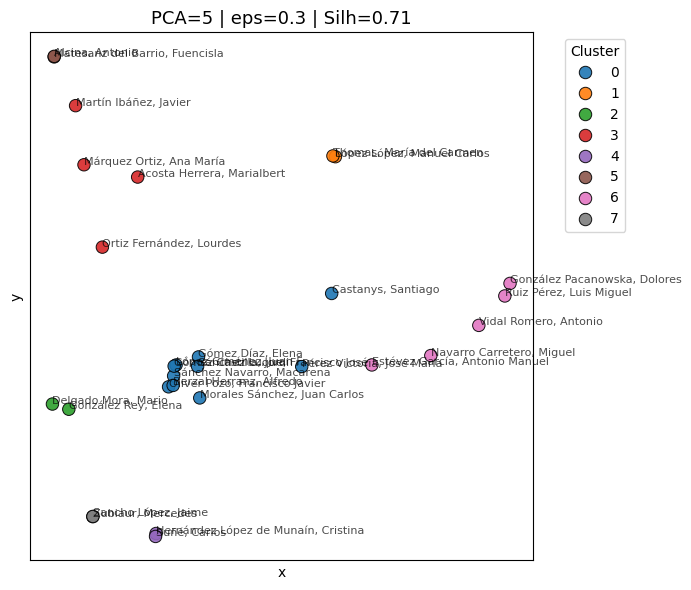

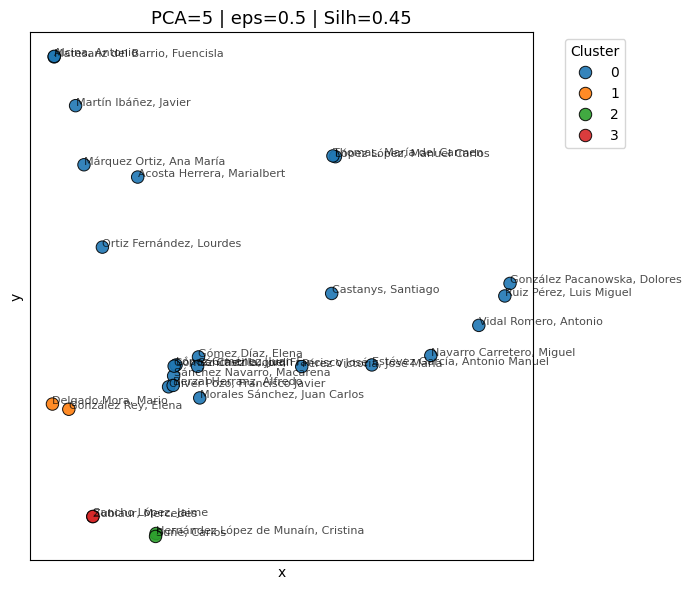

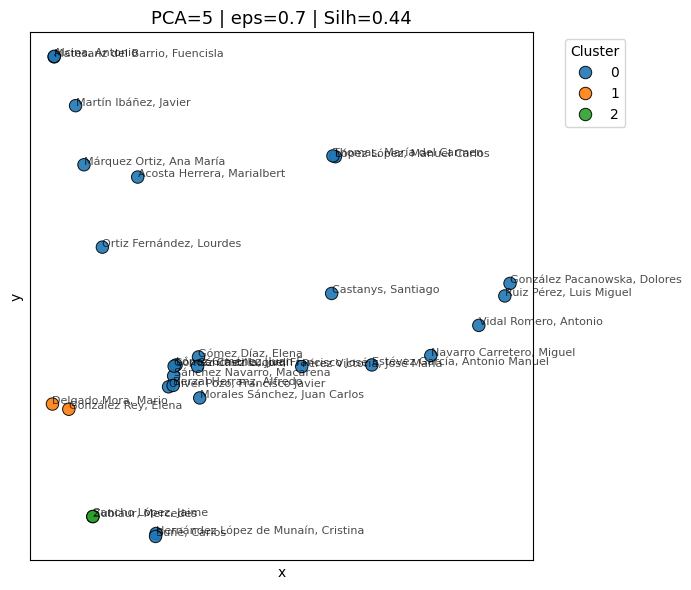

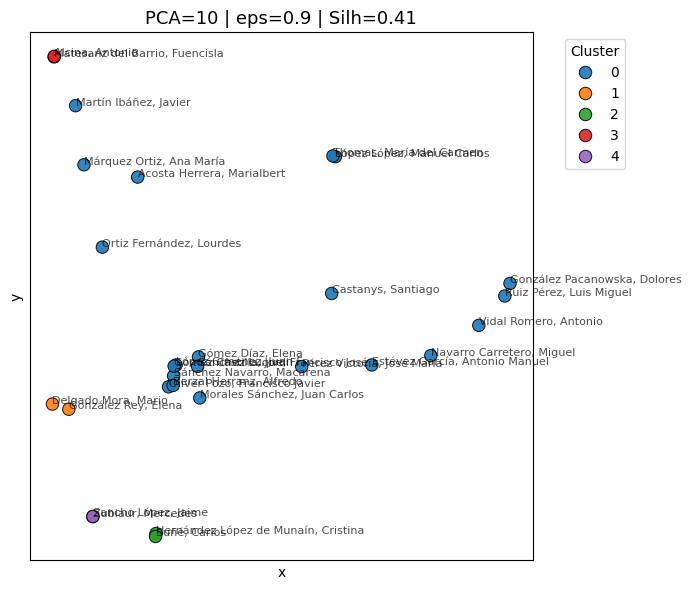

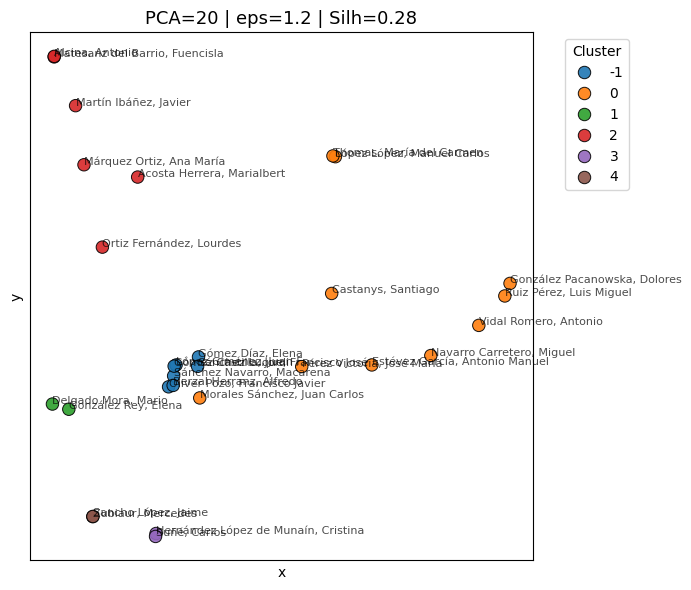

In [7]:
## Visualización de las configuraciones óptimas
X_2d = PCA(n_components=2).fit_transform(X_normalized)

for _, row in best_per_eps.iterrows():
    labels = row["Labels"]
    coords_df = pd.DataFrame(X_2d, columns=["x", "y"])
    coords_df["author"] = df.index
    coords_df["cluster"] = labels

    plt.figure(figsize=(7, 6), dpi=100)
    sns.scatterplot(
        data=coords_df,
        x="x", y="y",
        hue="cluster",
        palette="tab10",
        s=80,
        edgecolor='k',
        alpha=0.9
    )

    for _, r in coords_df.iterrows():
        plt.text(r["x"], r["y"], r["author"], fontsize=8, alpha=0.7)

    plt.title(f"PCA={row['PCA_dims']} | eps={row['eps']} | Silh={row['Silhouette']:.2f}", fontsize=13)
    plt.xticks([])
    plt.yticks([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Guardamos los resultados

In [8]:
cluster_records = []

for _, row in best_per_eps.iterrows():
    labels = row["Labels"]
    eps = row["eps"]
    pca_dims = row["PCA_dims"]
    silhouette = row["Silhouette"]
    ch_score = row["Calinski-Harabasz"]
    db_score = row["Davies-Bouldin"]

    for author, cluster in zip(df.index, labels):
        cluster_records.append({
            "author": author,
            "cluster": int(cluster),
            "eps": eps,
            "pca_dims": pca_dims,
            "silhouette": silhouette,
            "calinski_harabasz": ch_score,
            "davies_bouldin": db_score
        })

df_clusters_export = pd.DataFrame(cluster_records)
df_clusters_export.to_csv("Keywords/DBSCAN/dbscan_best_configs.csv", index=False)

print("✅ Resultados DBSCAN guardados.")

✅ Resultados DBSCAN guardados.
